# Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from flask import Flask, request, jsonify

# Load the dataset
file_path = "samsung_stock.csv"
data = pd.read_csv(file_path)

# Rename the first column to "Date"
data.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Display the first few rows
data.head()

2024-12-06 12:27:46.005830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 12:27:46.029600: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 12:27:46.182596: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 12:27:46.283258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733462866.376428    2744 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733462866.41

,Date,Adj Close,Close,High,Low,Open,Volume
0,2007-01-02,9109.592773,12520.0,12540.0,12320.0,12400.0,17607300
1,2007-01-03,8934.966797,12280.0,12560.0,12220.0,12540.0,19676500
2,2007-01-04,8818.548828,12120.0,12240.0,12060.0,12220.0,18258900
3,2007-01-05,8658.477539,11900.0,12180.0,11900.0,12160.0,28400400
4,2007-01-08,8498.408203,11680.0,11880.0,11580.0,11840.0,33081550


# EDA

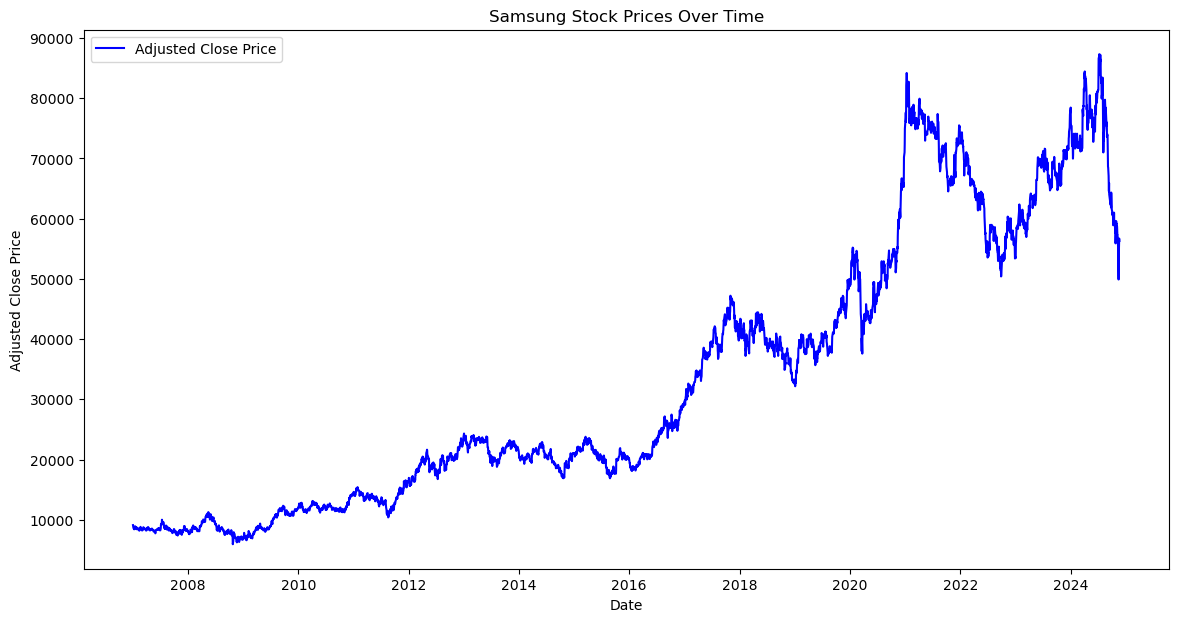

In [2]:
# Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot 'Adj Close'
plt.figure(figsize=(14, 7))
plt.plot(data['Adj Close'], label='Adjusted Close Price', color='b')
plt.title("Samsung Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

# Build Model

In [3]:
# Normalize the 'Adj Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Adj Close']])

# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Set sequence length (e.g., 60 days)
sequence_length = 60
x, y = create_sequences(data_scaled, sequence_length)

# Split data into train and test sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Train Model

In [4]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

W0000 00:00:1733462871.438702    2744 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/pen/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0156 - val_loss: 8.2434e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0012 - val_loss: 7.7421e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 8.7134e-04 - val_loss: 7.3091e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 7.7240e-04 - val_loss: 0.0017
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 6.8163e-04 - val_loss: 7.7607e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 5.0689e-04 - val_loss: 6.3718e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 5.0014e-04 - val_loss: 6.6366e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 4.3958e-04 - val_loss: 9.0170e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 5.0035e-04 - val_loss: 7.6389e-04
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 5.9336e-04 - val_loss: 6.0866e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss:

# Evaluasi Model

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 


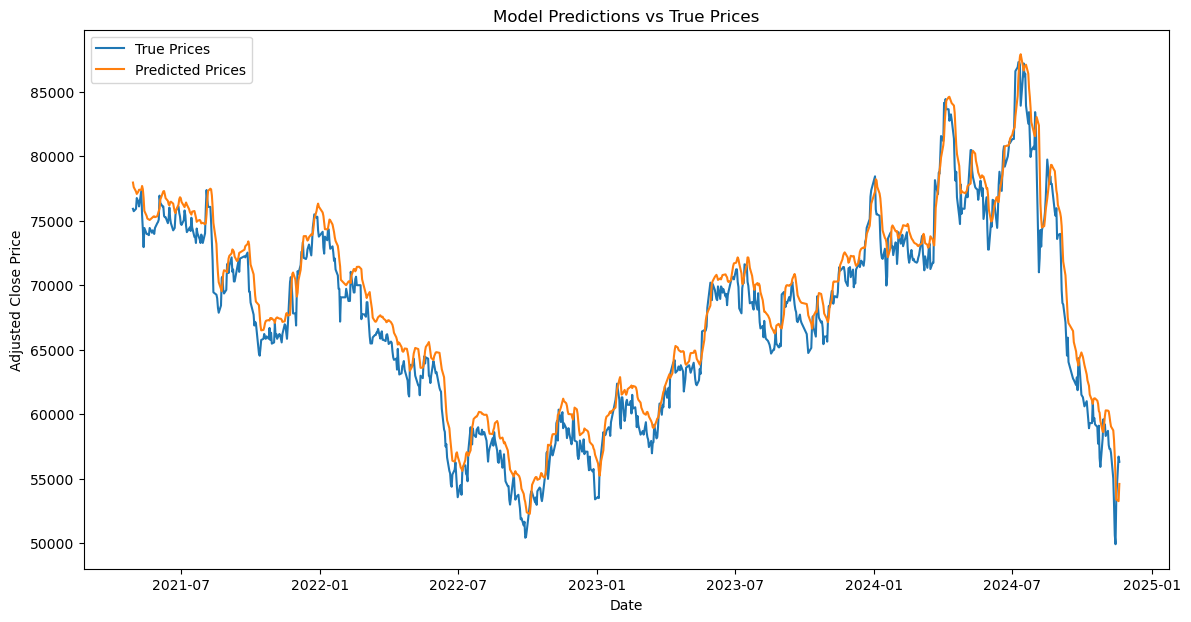

In [5]:
# Predict on test data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(predictions):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Prices')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted Prices')
plt.title("Model Predictions vs True Prices")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

# Prediksi 5 hari kedepan

In [6]:
# Predict the next 5 days
last_sequence = data_scaled[-sequence_length:]
predicted_prices = []
current_sequence = last_sequence

for _ in range(5):
    prediction = model.predict(current_sequence[np.newaxis, :, :])
    predicted_prices.append(prediction[0, 0])
    current_sequence = np.append(current_sequence[1:], prediction, axis=0)

# Inverse transform predictions
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))
print("Predicted Prices for the Next Week:")
print(predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Prices for the Next Week:
[[55962.26 ]
 [56879.027]
 [57617.05 ]
 [58278.777]
 [58905.965]]


In [7]:
import pickle

# Save the LSTM model
model.save("lstm_model.h5")
model.save("lstm_model.keras")

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)